In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm

import scipy.stats as scs
from scipy.special import erfinv

# Solver

In [3]:
def Euler(f, y0, t, args=()):
    n = len(t)
    h = t[1] - t[0]
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i + 1] = y[i] + h * f(y[i], t[i], *args)
    return y


def RK2(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        y[i + 1] = y[i] + k2 * h
    return y

@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y


# 1st order Kuramoto (simple Kuramoto)
ref :  Kuramoto, Yoshiki (1975). H. Araki (ed.). Lecture Notes in Physics, International Symposium on Mathematical Problems in Theoretical Physics. Vol. 39. Springer-Verlag, New York. p. 420.

In [4]:
@jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

@jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta

# With network
@jit(nopython=True)
def Kuramoto(Theta,t,omega,N,K,mk,Aij):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
    Theta[:N] = dtheta
    return Theta



## $g(\omega) = \text{Lorentzian}$

In [51]:
N = 500
Ks = np.linspace(0,4,41)
mean = 0
sigma = 1
np.random.seed(0)
init_theta = np.random.uniform(0,np.pi*2,N)
init_omega = np.array([sigma*np.tan(np.pi/2 * (2*i - N - 1)/(N+1)) + mean for i in range(1,N+1)])
Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
print(Kc)

2.0


Text(0.5, 1.0, '$g(\\omega) = \\text{Lorentzian}$')

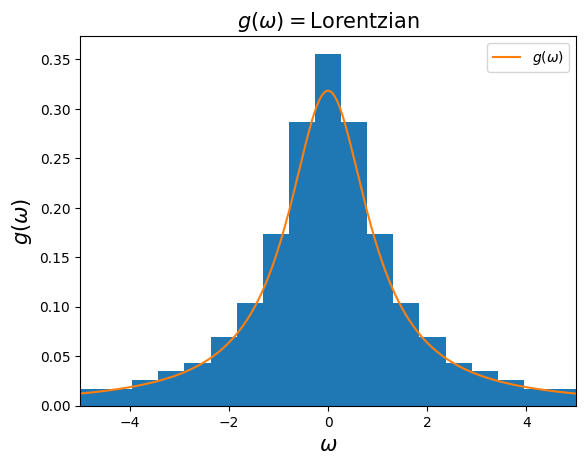

In [52]:
xs = np.linspace(-5,5,1000)
bins = np.linspace(-5,5,20)
plt.hist(init_omega,bins=bins,density=True)
plt.plot(xs,scs.cauchy.pdf(xs, mean, sigma),label=r'$g(\omega)$')
plt.xlim(-5,5)
plt.legend()
plt.ylabel(r'$g(\omega)$',fontsize=15)
plt.xlabel(r'$\omega$',fontsize=15)
plt.title(r'$g(\omega) = \text{Lorentzian}$',fontsize=15)

In [53]:
dt = 0.1
t = np.arange(0,100+dt/2,dt)
K_rs = []
K_rm = []
K_theta_last = []
for K in tqdm(Ks):
    sol = RK4(Kuramoto_mf,init_theta,t, args=(init_omega,N,K))
    theta_s = sol[:,:N]
    dtheta_s = sol[:,N:2*N] 
    rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
    r = np.abs(rphi)
    rm = np.mean(r[-5000:])
    K_theta_last.append((sol[-1]+np.pi)%(np.pi*2)-np.pi)
    K_rs.append(r)
    K_rm.append(rm)

100%|██████████| 41/41 [00:01<00:00, 23.72it/s]


Text(0.5, 0, '$K$')

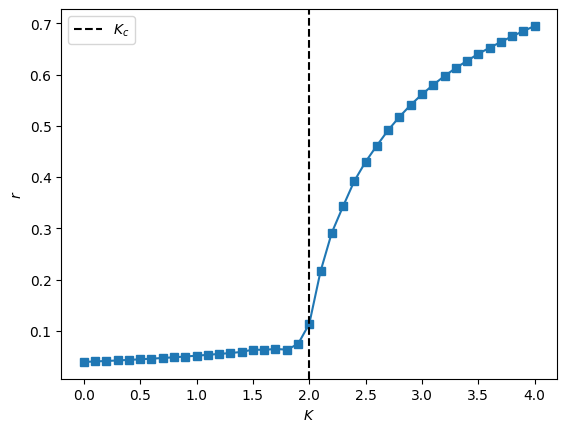

In [54]:
plt.plot(Ks,K_rm,'s-')
plt.axvline(Kc,label=r'$K_c$',ls='--',color='black')
plt.legend()
plt.ylabel(r'$r$')
plt.xlabel(r'$K$')

Text(0, 0.5, '$r$')

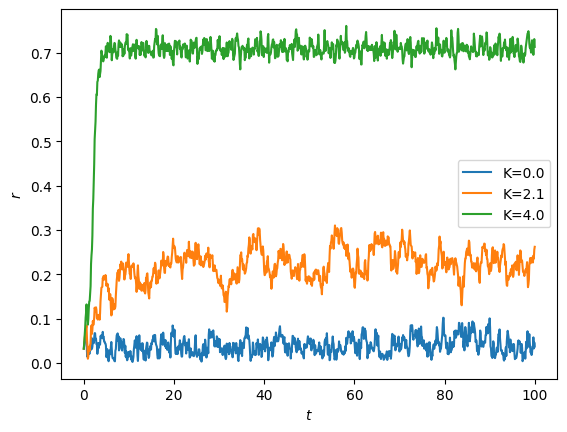

In [55]:
for K,K_r in zip(Ks,K_rs):
    if K in [Ks[0],Ks[21],Ks[-1]]:
        plt.plot(t,K_r,label=f'K={K}')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')

## $g(\omega) = \text{Normal}$

In [61]:
N = 500
Ks = np.linspace(0,4,41)
mean = 0
sigma = 1
np.random.seed(0)
init_theta = np.random.uniform(0,np.pi*2,N)
init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
Kc = 2 / (np.pi * scs.norm.pdf(mean, mean, sigma))
print(Kc)

1.5957691216057306


Text(0.5, 1.0, '$g(\\omega) = \\text{Normal}$')

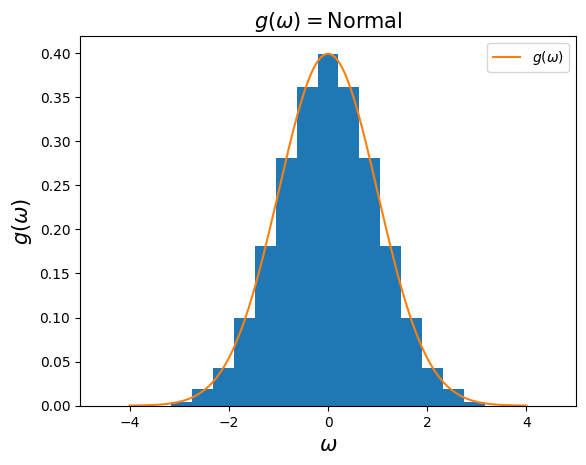

In [58]:
xs = np.linspace(-4,4,1000)
bins = np.linspace(-4,4,20)
plt.hist(init_omega,bins=bins,density=True)
plt.plot(xs,scs.norm.pdf(xs, mean, sigma),label=r'$g(\omega)$')
plt.xlim(-5,5)
plt.legend()
plt.ylabel(r'$g(\omega)$',fontsize=15)
plt.xlabel(r'$\omega$',fontsize=15)
plt.title(r'$g(\omega) = \text{Normal}$',fontsize=15)

In [62]:
dt = 0.1
t = np.arange(0,100+dt/2,dt)
K_rs = []
K_rm = []
K_theta_last = []
for K in tqdm(Ks):
    sol = RK4(Kuramoto_mf,init_theta,t, args=(init_omega,N,K))
    theta_s = sol[:,:N]
    dtheta_s = sol[:,N:2*N] 
    rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
    r = np.abs(rphi)
    rm = np.mean(r[-5000:])
    K_theta_last.append((sol[-1]+np.pi)%(np.pi*2)-np.pi)
    K_rs.append(r)
    K_rm.append(rm)

100%|██████████| 41/41 [00:01<00:00, 27.12it/s]


Text(0.5, 0, '$K$')

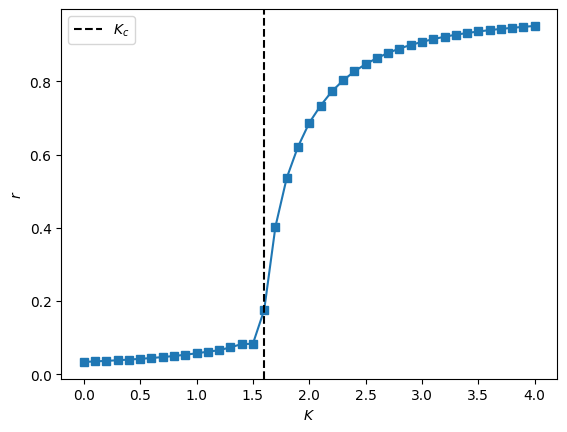

In [63]:
plt.plot(Ks,K_rm,'s-')
plt.axvline(Kc,label=r'$K_c$',ls='--',color='black')
plt.legend()
plt.ylabel(r'$r$')
plt.xlabel(r'$K$')

Text(0, 0.5, '$r$')

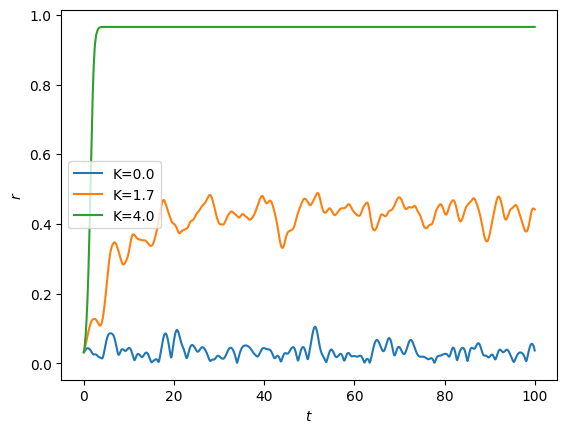

In [69]:
for K,K_r in zip(Ks,K_rs):
    if K in [Ks[0],Ks[17],Ks[-1]]:
        plt.plot(t,K_r,label=f'K={K:.01f}')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')

# 2nd order Kuramoto